In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Exploratory Data Analysis
* Understand user behavior, not just statistics
* Identify strong conversion signals
* Prepare stories for feature engineering
* Demonstrate product thinking

## 1.1 Dataset Overview

Dataset berisi 12.330 sesi pengguna e-commerce dengan:

* Behavioral features (page visits, duration)
* Technical features (browser, OS)
* Temporal features (Month, Weekend)
* Target: Revenue (binary)

In [4]:
df = pd.read_csv("/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv")
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


## 1.2 Dataset Shape & Info
* The dataset contains a mix of numerical and categorical features.
* There are no explicit missing values in the data.
* The target variable is highly imbalanced

In [5]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

## 1.3 Target Distribution

* Only ~15% of sessions result in revenue
* Accuracy is not an appropriate evaluation metric in this case: precision, recall, and F1-based metrics are more suitable

In [6]:
df['Revenue'].value_counts(normalize=True)

Revenue
False    0.845255
True     0.154745
Name: proportion, dtype: float64

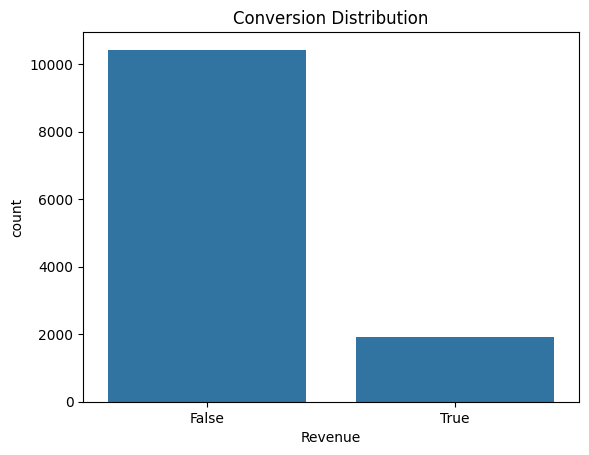

In [7]:
sns.countplot(x='Revenue', data=df)
plt.title("Conversion Distribution")
plt.show()

## 1.4 Behavioral Features Analysis

* Sessions with longer ProductRelated duration are more likely to lead to a purchase
* Behavioral engagement signals (e.g., time spent interacting with products) are strong indicators of conversion

In [8]:
behavioral_cols = [
    'Administrative_Duration',
    'Informational_Duration',
    'ProductRelated_Duration'
]

df.groupby('Revenue')[behavioral_cols].mean()

,Administrative_Duration,Informational_Duration,ProductRelated_Duration
Revenue,,,
False,73.740111,30.236237,1069.987809
True,119.483244,57.611427,1876.209615


# 2. Data Preprocessing & Feature Engineering

## 2.1 Feature-Target Separation

In [9]:
X = df.drop(columns='Revenue')
y = df['Revenue']

## 2.2 Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## 2.3 Feature Type Identification

In [12]:
num_features = X_train.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include=['object', 'bool']).columns

## 2.4 Preprocessing Pipeline

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [14]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

## 2.5 Class Imbalance Handling

In [15]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
scale_pos_weight

/tmp/ipykernel_55/550530817.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


np.float64(5.463958060288335)

## 2.6 Final Dataset Summary

In [16]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Positive rate:", y.mean())

Train size: (9864, 17)
Test size: (2466, 17)
Positive rate: 0.15474452554744525


# 3. Modeling & Baseline Comparison

## 3.1 Evaluation Metric Selection
Due to the imbalanced nature of the data, we use:
* Precision
* Recall
* F1-score
* ROC-AUC

## 3.2 Baseline Model: Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [18]:
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Month', 'VisitorType', 'Weekend'], dtype='object'))])),
                ('model', LogisticRegression(max_iter=1000))])

## 3.3 Tree-Based Model: Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight='balanced'
    ))
])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'O...'Browser', 'Region', 'TrafficType'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Month', 'VisitorType', 'Weekend'], dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

## 3.4 Gradient Boosting: XGBoost

In [20]:
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss',
        random_state=42
    ))
])

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'O...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=300, n_jobs=None,
                               num_parallel_tree=None, ...))])

## 3.5 Model Comparison

In [21]:
from sklearn.metrics import classification_report

models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline
}

for name, model in models.items():
    print(f"\n{name}")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Logistic Regression
              precision    recall  f1-score   support

       False       0.89      0.98      0.93      2084
        True       0.74      0.36      0.48       382

    accuracy                           0.88      2466
   macro avg       0.82      0.67      0.71      2466
weighted avg       0.87      0.88      0.86      2466


Random Forest
              precision    recall  f1-score   support

       False       0.92      0.97      0.94      2084
        True       0.74      0.52      0.61       382

    accuracy                           0.90      2466
   macro avg       0.83      0.74      0.78      2466
weighted avg       0.89      0.90      0.89      2466


XGBoost
              precision    recall  f1-score   support

       False       0.95      0.90      0.93      2084
        True       0.59      0.75      0.66       382

    accuracy                           0.88      2466
   macro avg       0.77      0.83      0.79      2466
weighted avg       0.90      

**Best model: XGBoost**
* Higher recall for the Revenue = True class
* Able to capture non-linear behavioral patterns

# 4. Model Evaluation & Interpretability

## 4.1 Confusion Matrix

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay

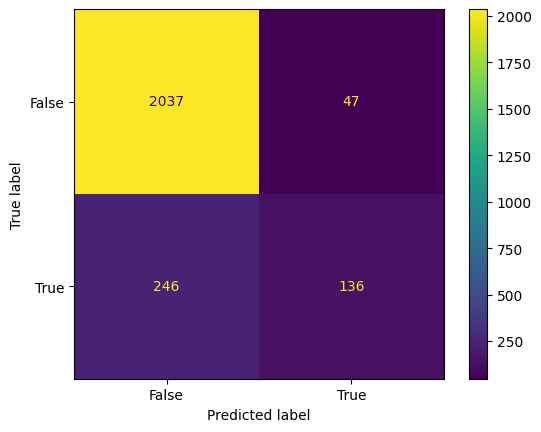

In [23]:
ConfusionMatrixDisplay.from_estimator(
    logreg_pipeline,
    X_test,
    y_test
)
plt.show()

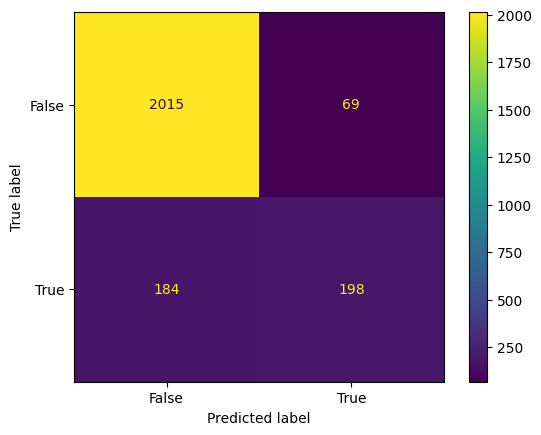

In [24]:
ConfusionMatrixDisplay.from_estimator(
    rf_pipeline,
    X_test,
    y_test
)
plt.show()

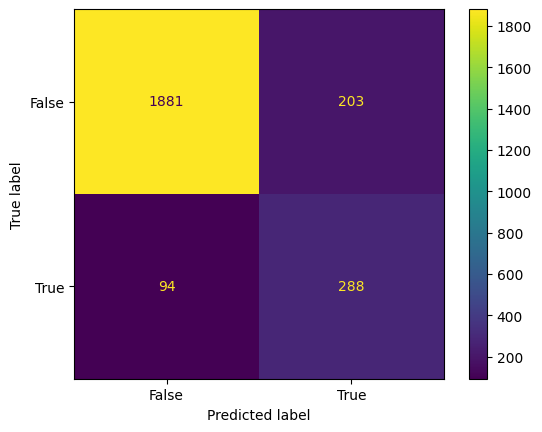

In [25]:
ConfusionMatrixDisplay.from_estimator(
    xgb_pipeline,
    X_test,
    y_test
)
plt.show()

## 4.2 Precision-Recall Trade-off

In [26]:
from sklearn.metrics import precision_recall_curve

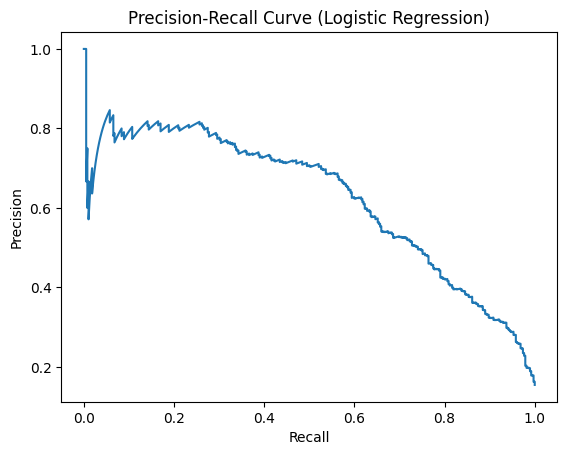

In [27]:
y_prob = logreg_pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Logistic Regression)")
plt.show()

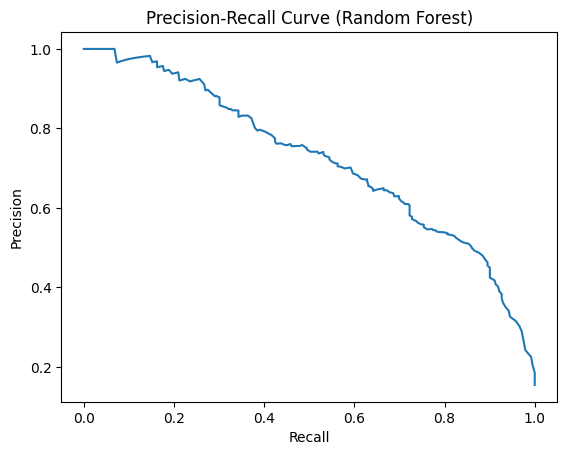

In [28]:
y_prob = rf_pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Random Forest)")
plt.show()

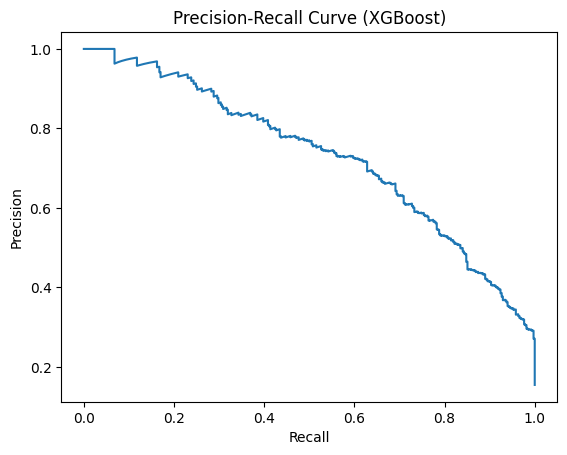

In [29]:
y_prob = xgb_pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()

## 4.3 ROC AUC Performance

In [30]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

### 4.3.1 ROC AUC + ROC Curve: Logistic Regressing

In [31]:
# Predict probability for positive class (purchase = 1)
y_prob = logreg_pipeline.predict_proba(X_test)[:, 1]

logreg_roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {logreg_roc_auc:.4f}")
print(f"The model has an {logreg_roc_auc * 100:.0f}% ability to distinguish between buyers and non-buyers at random.")

ROC AUC Score: 0.8876
The model has an 89% ability to distinguish between buyers and non-buyers at random.


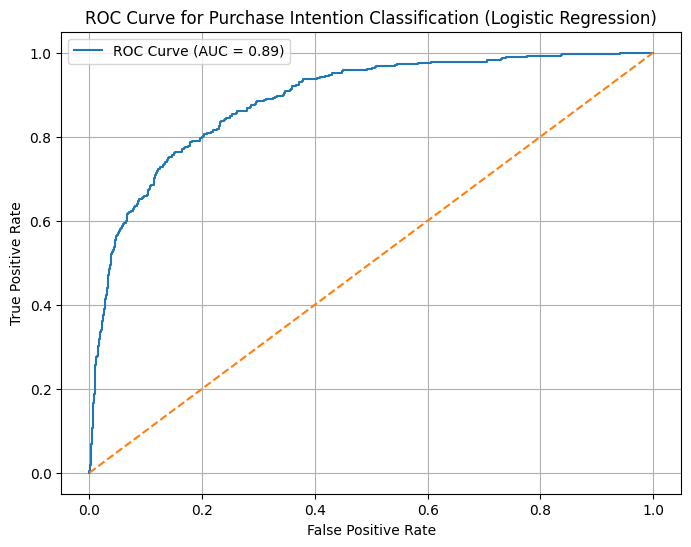

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {logreg_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Purchase Intention Classification (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### 4.3.1 ROC AUC + ROC Curve: Random Forest

In [33]:
# Predict probability for positive class (purchase = 1)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {rf_roc_auc:.4f}")
print(f"The model has an {rf_roc_auc * 100:.0f}% ability to distinguish between buyers and non-buyers at random")

ROC AUC Score: 0.9194
The model has an 92% ability to distinguish between buyers and non-buyers at random


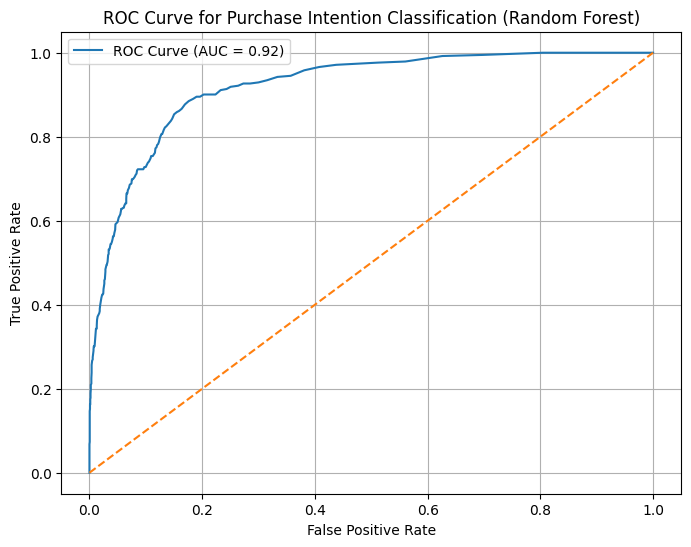

In [34]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {rf_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Purchase Intention Classification (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

### 4.3.1 ROC AUC + ROC Curve: XGBoost

In [35]:
# Predict probability for positive class (purchase = 1)
y_prob = xgb_pipeline.predict_proba(X_test)[:, 1]

xgb_roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {xgb_roc_auc:.4f}")
print(f"The model has an {xgb_roc_auc * 100:.0f}% ability to distinguish between buyers and non-buyers at random")

ROC AUC Score: 0.9257
The model has an 93% ability to distinguish between buyers and non-buyers at random


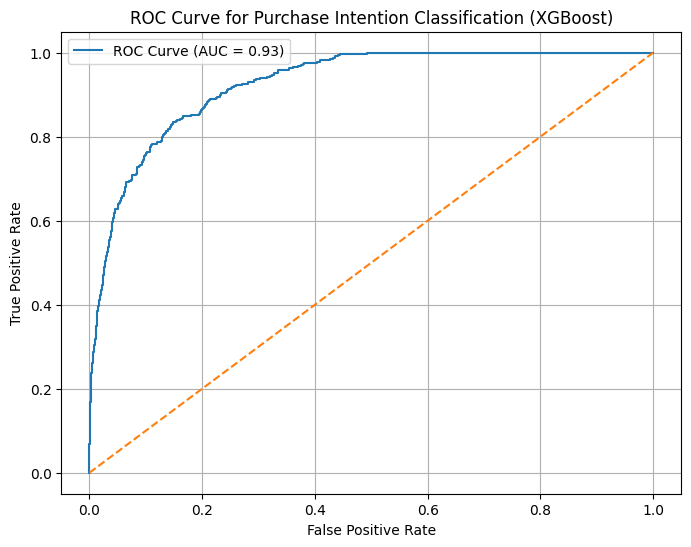

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {xgb_roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Purchase Intention Classification (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
print("ROC AUC Score")
print(f"- Logistic Regression : {logreg_roc_auc:.4f}")
print(f"- Random Forest       : {rf_roc_auc:.4f}")
print(f"- XGBoost             : {xgb_roc_auc:.4f}")

ROC AUC Score
- Logistic Regression : 0.8876
- Random Forest       : 0.9194
- XGBoost             : 0.9257


While precision and recall evaluate performance at a specific threshold, ROC AUC evaluates the overall ranking quality of the model. This makes ROC AUC especially valuable in imbalanced datasets, where accuracy alone can be misleading.

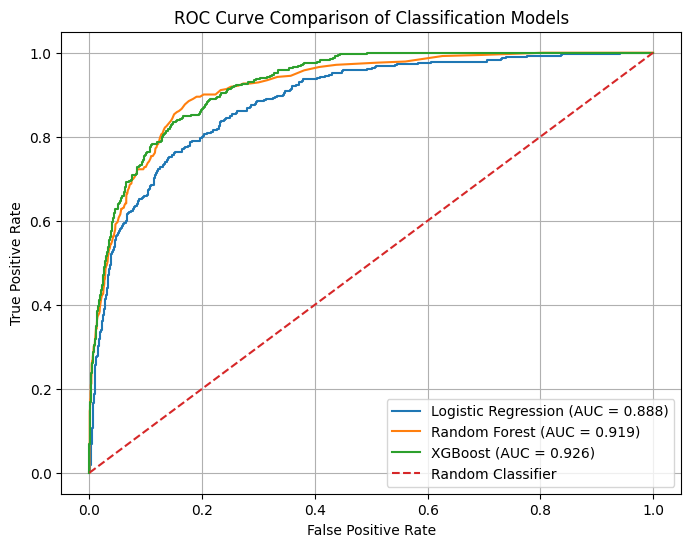

In [38]:
models = {
    "Logistic Regression": logreg_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline
}

plt.figure(figsize=(8, 6))

for name, model in models.items():
    # Probability for positive class
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # ROC metrics
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    
    # Plot
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], linestyle='--', label="Random Classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Classification Models")
plt.legend()
plt.grid(True)
plt.show()

## 4.3 SHAP Interpretability
SHAP analysis was performed using a model-agnostic explainer wrapped around the XGBoost probability output to ensure compatibility with an sklearn-based pipeline.

In [39]:
import shap

### Transform Data

In [41]:
X_train_trans = xgb_pipeline.named_steps['preprocessor'].transform(X_train).astype(float)
X_test_trans  = xgb_pipeline.named_steps['preprocessor'].transform(X_test).astype(float)

In [42]:
# Check if all elements are float
def all_elements_float(arr):
    return all(isinstance(x, float) for x in arr)

In [43]:
model = xgb_pipeline.named_steps['model']

In [44]:
# sklearn wrapper
def model_predict(X):
    return model.predict_proba(X)[:, 1]

### SHAP Explainer

In [45]:
explainer = shap.Explainer(model_predict, X_train_trans)
shap_values = explainer(X_test_trans)

PermutationExplainer explainer: 2467it [05:09,  7.81it/s]                          


### Feature Names

In [46]:
num_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()

cat_features = X_train.select_dtypes(include=['object','bool']).columns.tolist()
ohe = xgb_pipeline.named_steps['preprocessor'] \
    .named_transformers_['cat'] \
    .named_steps['onehot']

cat_names = ohe.get_feature_names_out(cat_features).tolist()
feature_names = num_features + cat_names

### SHAP Summary Plot

/tmp/ipykernel_55/3643738196.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


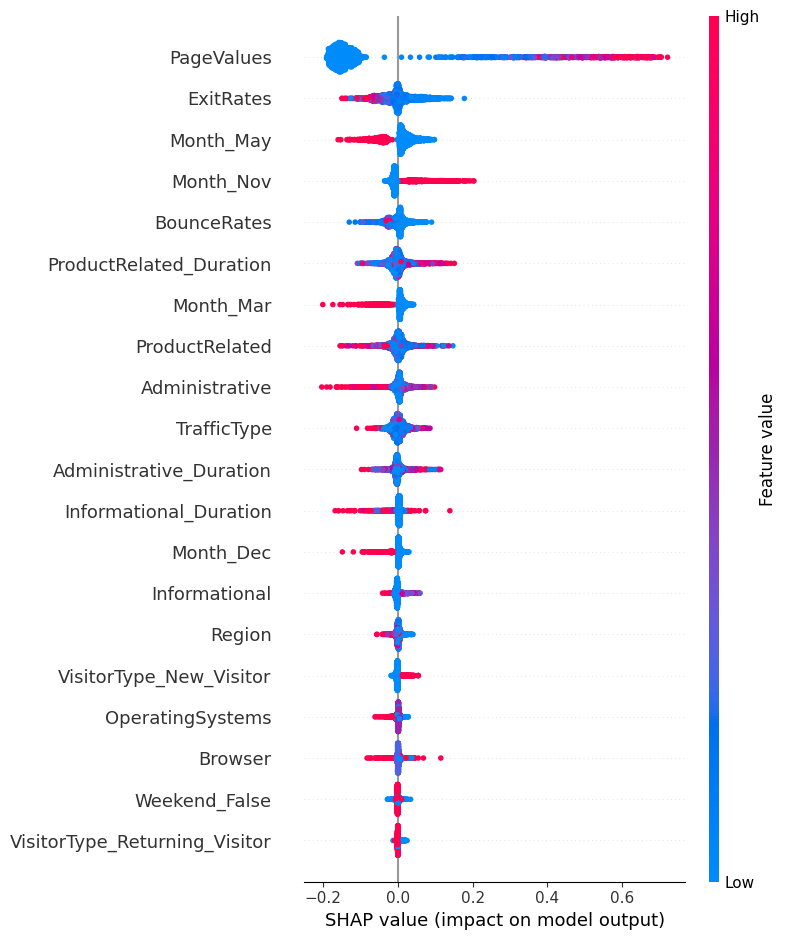

In [47]:
shap.summary_plot(
    shap_values.values,
    X_test_trans,
    feature_names=feature_names
)

This SHAP summary shows that purchase decisions are primarily driven by meaningful engagement with product pages rather than technical or demographic attributes. It reinforces the importance of designing experiences that encourage exploration and sustained interaction.

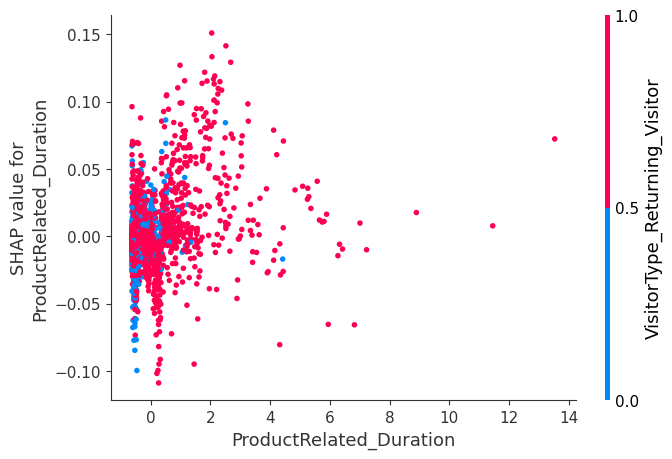

In [48]:
shap.dependence_plot(
    "ProductRelated_Duration",
    shap_values.values,
    X_test_trans,
    feature_names=feature_names,
    interaction_index="VisitorType_Returning_Visitor"
)

The interaction between `ProductRelated Duration` and `Returning Visitor` status reveals that prolonged engagement is significantly more predictive of purchase when the user is already familiar with the platform.

### Find Ideal Buyer
This is the user who is most confident about purchasing according to the model.

In [62]:
# Find the user index that has high confidence as ideal buyer
y_proba = model.predict_proba(X_test_trans)[:, 1]

idx_high_conf = y_proba.argmax()
idx_high_conf

np.int64(2060)

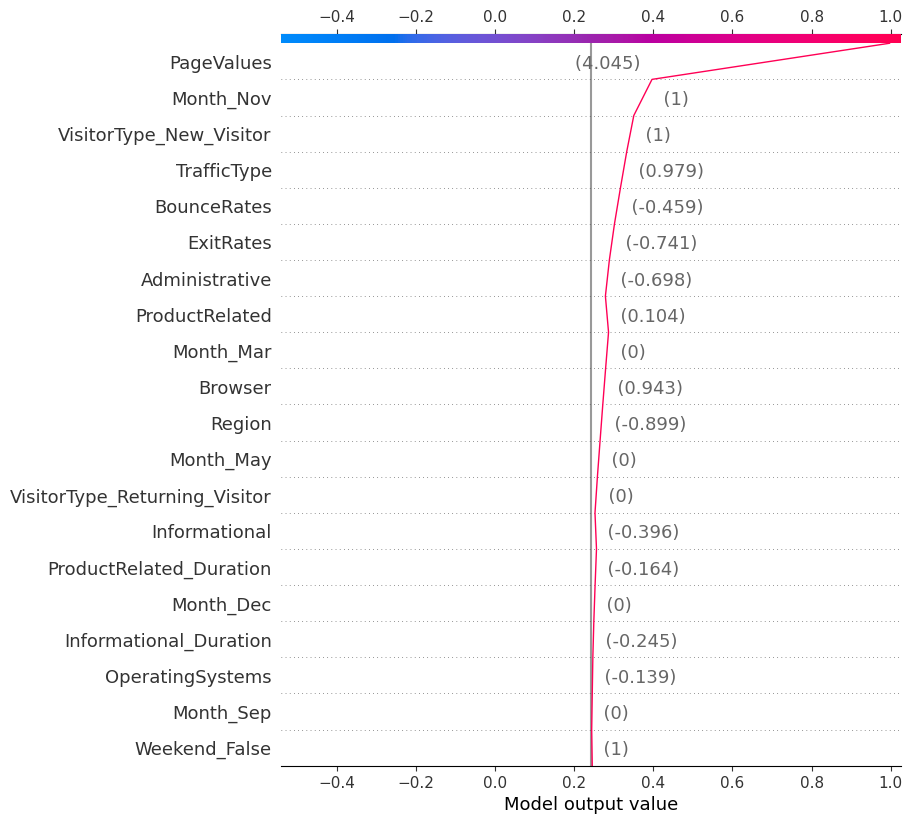

In [53]:
shap.decision_plot(
    shap_values.base_values[idx_high_conf],
    shap_values.values[idx_high_conf],
    X_test_trans[idx_high_conf],
    feature_names=feature_names,
    feature_order="importance",
    show=True
)

In [77]:
# Generate model predictions on the test set
y_pred = model.predict(X_test_trans)

# True Positive (TP)
# User actually makes a purchase and the model correctly predicts a purchase
true_positive_idx = np.where((y_test == 1) & (y_pred == 1))[0][0]
print("True Positive index  :", true_positive_idx)

# True Negative (TN)
# User does not make a purchase and the model correctly predicts no purchase
true_negative_idx = np.where((y_test == 0) & (y_pred == 0))[0][0]
print("True Negative index  :", true_negative_idx)

# False Positive (FP)
# Model predicts a purchase, but the user does not actually buy
false_positive_idx = np.where((y_test == 0) & (y_pred == 1))[0][0]
print("False Positive index :", false_positive_idx)

# False Negative (FN)
# User makes a purchase, but the model fails to predict it
false_negative_idx = np.where((y_test == 1) & (y_pred == 0))[0][0]
print("False Negative index :", false_negative_idx)

True Positive index  : 2
True Negative index  : 0
False Positive index : 16
False Negative index : 6


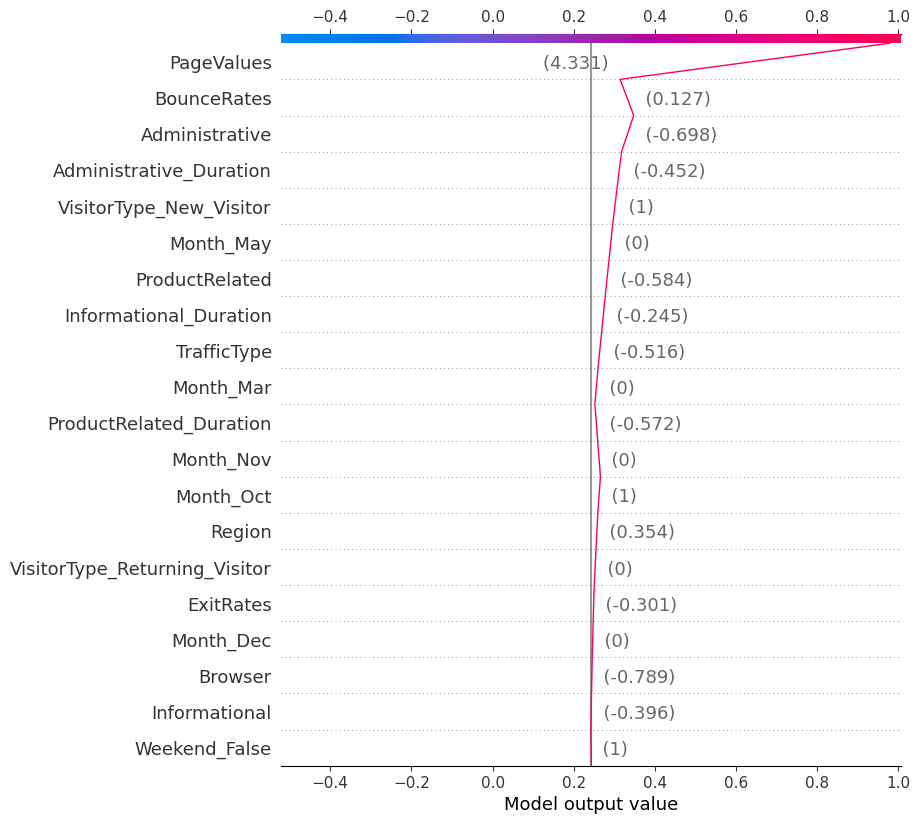

In [64]:
# True Positive (TP) - Decison Plot
# User actually makes a purchase and the model correctly predicts a purchase
shap.decision_plot(
    shap_values.base_values[true_positive_idx],
    shap_values.values[true_positive_idx],
    X_test_trans[true_positive_idx],
    feature_names=feature_names,
    feature_order="importance",
    show=True
)

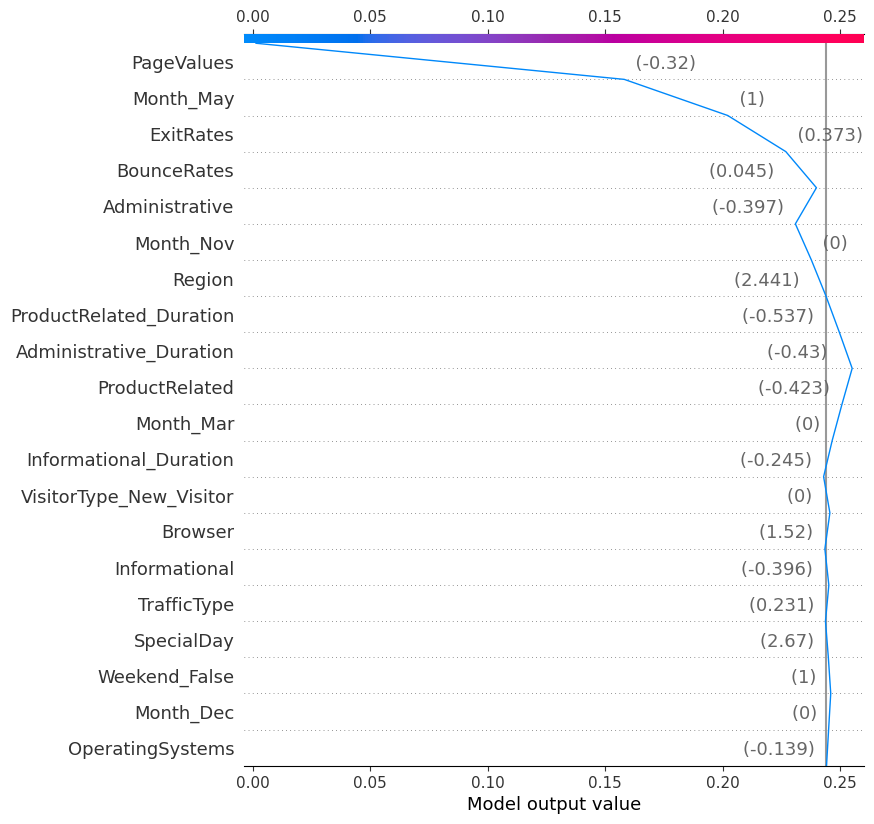

In [75]:
# True Negative (TN) - Decison Plot
# User does not make a purchase and the model correctly predicts no purchase
shap.decision_plot(
    shap_values.base_values[true_negative_idx],
    shap_values.values[true_negative_idx],
    X_test_trans[true_negative_idx],
    feature_names=feature_names,
    feature_order="importance",
    show=True
)

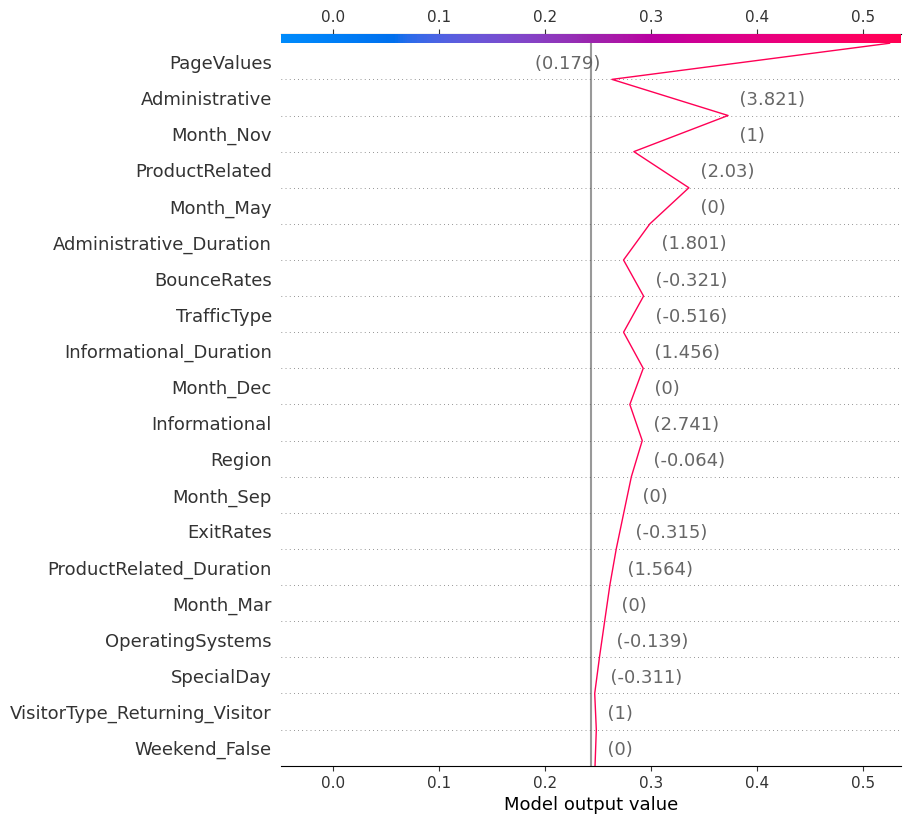

In [76]:
# False Positive (FP) - Decison Plot
# Model predicts a purchase, but the user does not actually buy
shap.decision_plot(
    shap_values.base_values[false_positive_idx],
    shap_values.values[false_positive_idx],
    X_test_trans[false_positive_idx],
    feature_names=feature_names,
    feature_order="importance",
    show=True
)

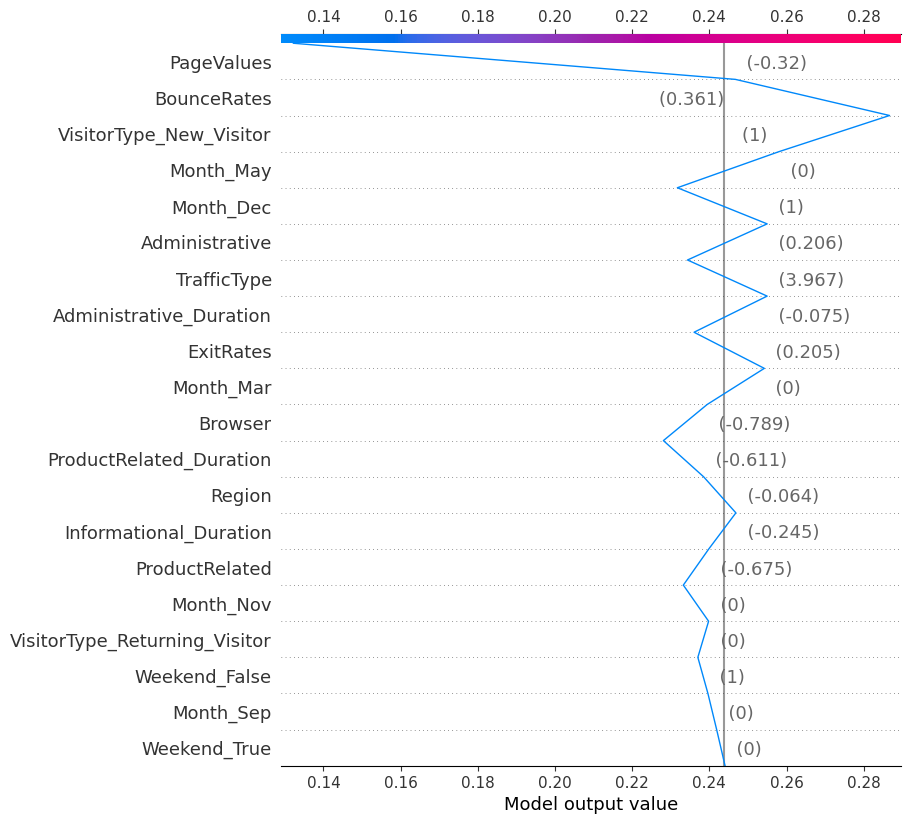

In [65]:
# False Negative (FN) - Decison Plot
# User makes a purchase, but the model fails to predict it
shap.decision_plot(
    shap_values.base_values[false_negative_idx],
    shap_values.values[false_negative_idx],
    X_test_trans[false_negative_idx],
    feature_names=feature_names,
    feature_order="importance",
    show=True
)

### Force Plot

In [68]:
shap.initjs()

In [78]:
# True Positive (TP) - Force Plot
# User actually makes a purchase and the model correctly predicts a purchase
shap.force_plot(
    shap_values.base_values[true_positive_idx],
    shap_values.values[true_positive_idx],
    X_test_trans[true_positive_idx],
    feature_names=feature_names
)

In [79]:
# True Negative (TN) - Force Plot
# User does not make a purchase and the model correctly predicts no purchase
shap.force_plot(
    shap_values.base_values[true_negative_idx],
    shap_values.values[true_negative_idx],
    X_test_trans[true_negative_idx],
    feature_names=feature_names
)

In [80]:
# False Positive (FP) - Force Plot
# Model predicts a purchase, but the user does not actually buy
shap.force_plot(
    shap_values.base_values[false_positive_idx],
    shap_values.values[false_positive_idx],
    X_test_trans[false_positive_idx],
    feature_names=feature_names
)

In [81]:
# False Negative (FN) - Force Plot
# User makes a purchase, but the model fails to predict it
shap.force_plot(
    shap_values.base_values[false_negative_idx],
    shap_values.values[false_negative_idx],
    X_test_trans[false_negative_idx],
    feature_names=feature_names
)

# 5. Key Business Insights
* User engagement quality matters more than sheer traffic volume. Time spent on product pages is a strong indicator of intent.
* Retention strategies deserve more attention than pure acquisition. Returning visitors are significantly more likely to convert, which means they have a higher probability of making a purchase.
* Timing matters. Purchasing behavior changes depending on seasonality and weekends, opening opportunities for more targeted campaigns.

# 6. Limitations & Future Work

**Limitations**

* The data is session-level rather than user-level, limiting long-term behavioral analysis.
* There is no information on product prices or promotional details.
* The dataset represents a static snapshot, without sequential or temporal dependency modeling.

**Future Work**
* Cost-based threshold optimization to better align predictions with business objectives.
* Analysis of SHAP interaction values to capture feature interactions.
* Session sequence modeling using LSTM or Transformer architectures.
* Uplift modeling for more effective campaign targeting.